## **Optimizing Retail Banking Strategies Through RFM-Based Customer Segmentation**

### **Objective:** Prepare transaction data for customer's insights and segmentation

### **Workflow:**

1. **Data loading** - Load raw data and initial inspection
2. **Data Cleaning** - Fix dates, times, types, and check duplicates
3. **Exploratory Data Analysis** - Understand distributions, patterns and outliers
4. **RFM Segmentation** - Build customer scores and segments
5. **Save outputs** - Export clean data for modeling/dashboards

## **Data Loading**

In [7]:
# import libararies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

sns.set_style("whitegrid")
pd.options.display.float_format = '{:.2f}'.format

In [8]:
# Load the data
df = pd.read_csv("../data/bank_data_C.csv")

# To print the top 5 rows
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50


In [9]:
# To print the bottom 5 rows

df.tail()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
1041609,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.00
1041610,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.00
1041611,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.00
1041612,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.00
1041613,T1048567,C8337524,5/3/84,M,PUNE,75734.42,18/9/16,181222,1166.00


##### ***Insight***: Confirm columns match the data dictionary from the instructions

In [11]:
# Investigate the dataset for annomalies and data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041614 entries, 0 to 1041613
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1041614 non-null  object 
 1   CustomerID               1041614 non-null  object 
 2   CustomerDOB              1041614 non-null  object 
 3   CustGender               1041614 non-null  object 
 4   CustLocation             1041614 non-null  object 
 5   CustAccountBalance       1041614 non-null  float64
 6   TransactionDate          1041614 non-null  object 
 7   TransactionTime          1041614 non-null  int64  
 8   TransactionAmount (INR)  1041614 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 71.5+ MB


In [12]:
# Check for duplicate values

df.duplicated().sum()

0

## **Data Cleaning**

##### **Rename columns** - Remove units like (INR) from the TransactionAmount column

In [15]:
df = df.rename(columns={"TransactionAmount (INR)": "TransactionAmount"})
list(df.columns)

['TransactionID',
 'CustomerID',
 'CustomerDOB',
 'CustGender',
 'CustLocation',
 'CustAccountBalance',
 'TransactionDate',
 'TransactionTime',
 'TransactionAmount']

#### **Parse dates**

##### Dates like 10/1/94 are ambiguous and pandas might misinterpret them. I normalise to DD/MM/YY first, then parse with an explicit format.

In [17]:
def normalise_dmy(x):
    """Normalise day-first dates to DD/MM/YY format."""
    if pd.isna(x): return np.nan
    try:
        d, m, y = str(x).strip().split('/')
        return f"{int(d):02}/{int(m):02d}/{int(y):02d}"
    except:
        return np.nan

for col in ["CustomerDOB", "TransactionDate"]:
    df[col] = df[col].map(normalise_dmy)
    df[col] = pd.to_datetime(df[col], format="%d/%m/%y", errors="coerce")

df[["CustomerDOB", "TransactionDate"]].head()

,CustomerDOB,TransactionDate
0,1994-01-10,2016-08-02
1,2057-04-04,2016-08-02
2,1996-11-26,2016-08-02
3,1973-09-14,2016-08-02
4,1988-03-24,2016-08-02


#### **Fix future DOBs**

##### **Issue:** Two-digit year parsing assumes 00-68 = 2000-2068. This creates future DOBs like 2057

##### **Fix:** Subtract 100 years from any DOB > today.

In [19]:
from pandas.tseries.offsets import DateOffset

mask = df["CustomerDOB"] > pd.Timestamp.today()
df.loc[mask, "CustomerDOB"] -= DateOffset(years=100)
print(f"fixed {mask.sum()} future DOBs")
df[["CustomerDOB"]].head(10)


fixed 54111 future DOBs


,CustomerDOB
0,1994-01-10
1,1957-04-04
2,1996-11-26
3,1973-09-14
4,1988-03-24
5,1972-10-08
6,1992-01-26
7,1982-01-27
8,1988-04-19
9,1984-06-22


In [20]:
df.isna().sum()

TransactionID             0
CustomerID                0
CustomerDOB           56292
CustGender                0
CustLocation              0
CustAccountBalance        0
TransactionDate           0
TransactionTime           0
TransactionAmount         0
dtype: int64

In [21]:
df.dropna(inplace = True)

In [22]:
df.isna().sum()

TransactionID         0
CustomerID            0
CustomerDOB           0
CustGender            0
CustLocation          0
CustAccountBalance    0
TransactionDate       0
TransactionTime       0
TransactionAmount     0
dtype: int64

#### **Parse transaction time**

##### Combine date + time for accurate temporal analysis (e.g., hourly patterns).

In [24]:
tt = df["TransactionTime"].astype(str).str.zfill(6)
df["TransactionDateTime"] = pd.to_datetime(
    df["TransactionDate"].dt.strftime("%Y-%m-%d") + " " + tt,
    format="%Y-%m-%d %H%M%S", errors="coerce"
)
print(f"Datetime nulls: {df['TransactionDateTime'].isna().sum()}")
df[["TransactionDate", "TransactionTime", "TransactionDateTime"]].head()

Datetime nulls: 0


,TransactionDate,TransactionTime,TransactionDateTime
0,2016-08-02,143207,2016-08-02 14:32:07
1,2016-08-02,141858,2016-08-02 14:18:58
2,2016-08-02,142712,2016-08-02 14:27:12
3,2016-08-02,142714,2016-08-02 14:27:14
4,2016-08-02,181156,2016-08-02 18:11:56


#### Check Duplicate

In [26]:
exact_dups = df.duplicated().sum()
txid_dups = df["TransactionID"].duplicated().sum()
print(f"Exact duplicates: {exact_dups}")
print(f"Duplicate TransactionIDs: {txid_dups}")

Exact duplicates: 0
Duplicate TransactionIDs: 0


###### ***Insight:*** No duplicates found - all rows are unique transactions

### **Exploratory Data Analysis (EDA)**

In [29]:
# Summary Statistics

summary = {
    "Total rows": len(df),
    "Unique Customers": df["CustomerID"].nunique(),
    "Date Range": f"{df['TransactionDate'].min().date()} to {df['TransactionDate'].max().date()}",
    "Missing DOB": df["CustomerDOB"].isna().sum()
}
pd.Series(summary)

Total rows                            985322
Unique Customers                      839081
Date Range          2016-08-01 to 2016-10-21
Missing DOB                                0
dtype: object

In [30]:
df[["CustAccountBalance", "TransactionAmount"]].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
CustAccountBalance,985322.00,106061.19,817905.35,0.00,3.47,68.20,4582.13,16006.30,53759.08,384449.13,1413986.83,115035495.10
TransactionAmount,985322.00,1452.43,6139.77,0.00,8.56,29.00,151.00,431.00,1125.00,5000.00,18345.37,1560034.99


##### ***Insight:*** 
* There are 839k unique customers, over 985k transactions
* Heavy right skew: 99th percentile for both account balance and transaction amount
* This suggests extreme outliers that could dominate plots and distort insights

#### **Outlier detection**

##### Method 1: IQR(Interquartile Range)
* Calculate Q1 (25th percentile) and Q3 (75th percentile)
* IQR = Q3 - Q1
* Outliers are values < Q1 - 1.5xIQR or > Q3 + 1.5xIQR
* Pro: Standard statistical method, robust to extreme values
* Con: Can flag too many points in skewed distribution

In [33]:
# Method 1: IQR-based outlier detection
def iqr_outliers(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return lower, upper, (series < lower).sum(), (series > upper).sum()

print("=== IQR METHOD ===")
for col in ["TransactionAmount", "CustAccountBalance"]:
    lower, upper, n_low, n_high = iqr_outliers(df[col].dropna())
    pct_outliers = 100 * (n_low + n_high) / len(df)
    print(f"\n{col}:")
    print(f" IQR bounds: [{lower:,.2f}, {upper:,.2f}]")
    print(f" Outliers: {n_low} below, {n_high} above ({pct_outliers:.1f}% total)")

=== IQR METHOD ===

TransactionAmount:
 IQR bounds: [-1,310.00, 2,586.00]
 Outliers: 0 below, 105766 above (10.7% total)

CustAccountBalance:
 IQR bounds: [-69,183.29, 127,524.50]
 Outliers: 0 below, 130660 above (13.3% total)


##### Method 2: Percentile thresholds
* Flag values below 1st percentile or above 99th percentile
* Pro: Simple, controls outlier proportion (keeps 98% of data)
* Con: Arbirary cutoffs

In [35]:
# Method 2: Percentile-based outlier detection

print ("\n=== Percentile Method (1% / 99%) ===")
for col in ["TransactionAmount", "CustAccountBalance"]:
    p1, p99 = df[col].quantile([0.01, 0.99])
    n_below = (df[col] < p1).sum()
    n_above = (df[col] > p99).sum()
    print(f"\n{col}:")
    print(f" 1st percentile: {p1:,.2f}")
    print(f" 99th percentile: {p99:,.2f}")
    print(f" Outliers: {n_below} below, {n_above} above (2% by definition)")


=== Percentile Method (1% / 99%) ===

TransactionAmount:
 1st percentile: 8.56
 99th percentile: 18,345.37
 Outliers: 9851 below, 9854 above (2% by definition)

CustAccountBalance:
 1st percentile: 3.47
 99th percentile: 1,413,986.83
 Outliers: 9831 below, 9854 above (2% by definition)


#### **Decision: Capping strategy**

 ***Problem:*** Outliers will dominate visualizations (e.g., histograms compressed to the left, scatter plots unreadable).

 ***Solution:*** Create a capped copy for visualizations only
* Cap at 1st and 99th percentiles
* Keep raw data intact for modeling(algorithms like Random Forest handle outliers well)
* This balances visual clarity with data integrity

**Why 1%/99% instead of IQR?**
* IQR flags 10-13% of data as outliers (too aggressive for skewed banking data)
* 1%99% keeps 98% of observations, improving plot readability while retaining most variation

In [37]:
# Create a capped copy for plotting only

eda = df.copy()
for col in ["TransactionAmount", "CustAccountBalance"]:
    lower, upper = eda[col].quantile([0.01, 0.99])
    eda[col] = eda[col].clip(lower, upper)

print("Created capped copy 'eda' for visualizations")
print("Original 'df' remains unchanged for modelling")
eda[["TransactionAmount", "CustAccountBalance"]].describe().T

Created capped copy 'eda' for visualizations
Original 'df' remains unchanged for modelling


,count,mean,std,min,25%,50%,75%,max
TransactionAmount,985322.00,1231.72,2548.52,8.56,151.00,431.00,1125.00,18345.37
CustAccountBalance,985322.00,79465.40,201201.12,3.47,4582.13,16006.30,53759.08,1413986.83


### **Distribution Plots**

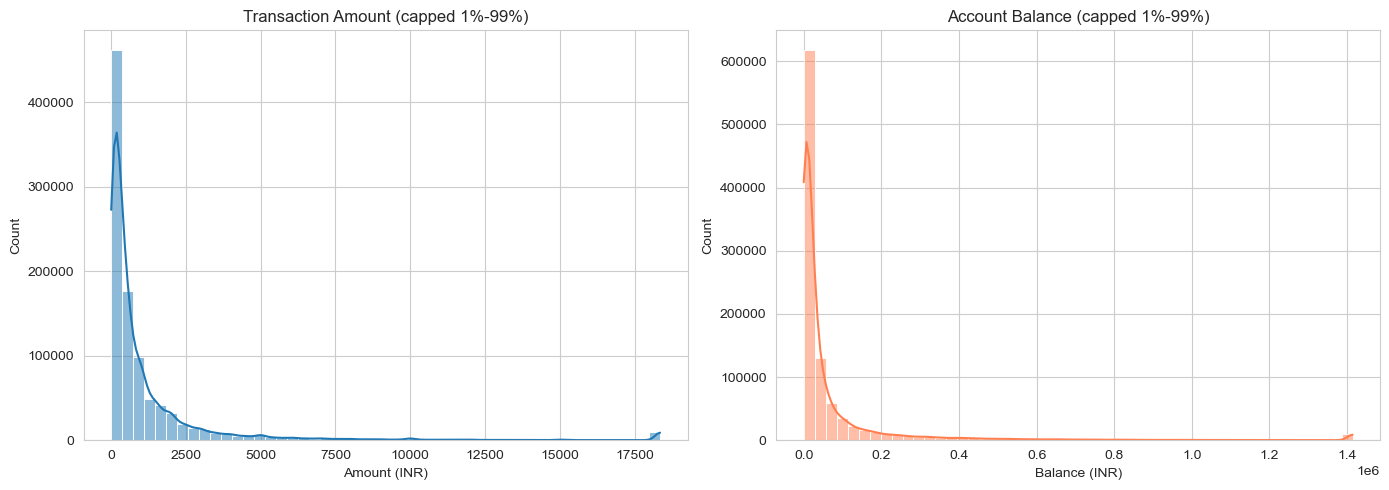

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.histplot(eda["TransactionAmount"], kde=True, ax=axes[0], bins=50)
axes[0].set_title("Transaction Amount (capped 1%-99%)")
axes[0].set_xlabel("Amount (INR)")
sns.histplot(eda["CustAccountBalance"], kde=True, ax=axes[1], bins=50, color="coral")
axes[1].set_title("Account Balance (capped 1%-99%)")
axes[1].set_xlabel("Balance (INR)")
plt.tight_layout()
plt.show()

***Insights:***

* Both distributions remain right-skewed even after capping
* Majority of the transactions are small, most balances are low-to-mid range
* Long tail suggests a small group of high-value customers drive large monetary volume

### **Categorical Analysis**

In [42]:
# Gender Distribution

print("Gender distribution:")
print(df["CustGender"].value_counts())
print(f"\nPercentage Male: {100*df['CustGender'].value_counts(normalize=True)['M']:.1f}%")

Gender distribution:
CustGender
M    712454
F    272868
Name: count, dtype: int64

Percentage Male: 72.3%


In [43]:
# Top 10 locations:

print("\nTop 10 locations:")
print(df["CustLocation"].value_counts().head(10))


Top 10 locations:
CustLocation
MUMBAI       97679
BANGALORE    77751
NEW DELHI    76380
GURGAON      70518
DELHI        67335
NOIDA        31675
CHENNAI      27500
PUNE         24493
HYDERABAD    21819
THANE        21006
Name: count, dtype: int64


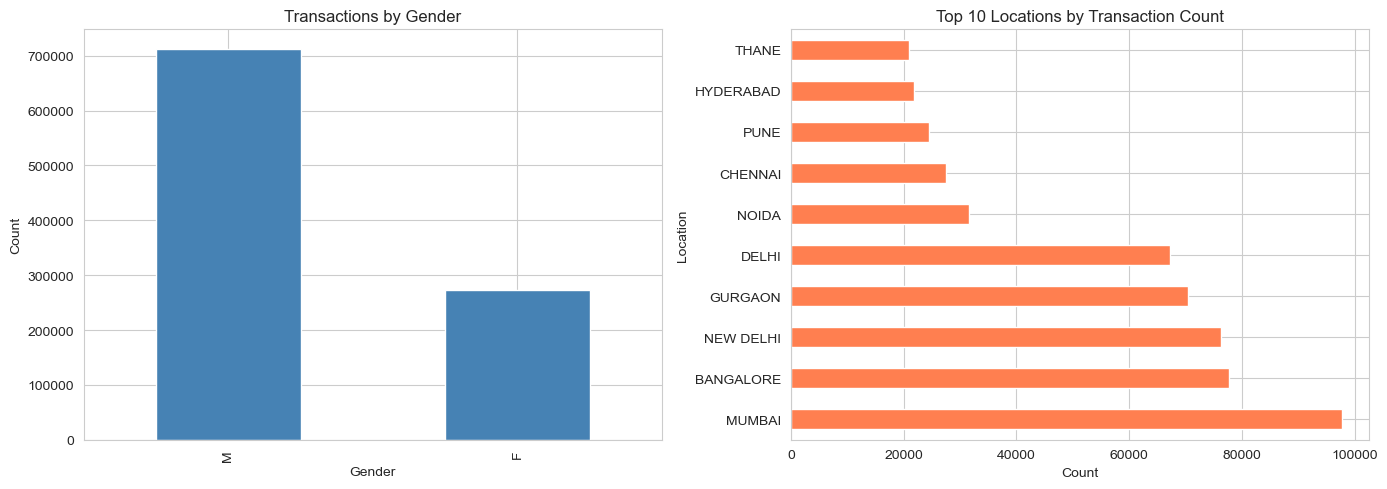

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df["CustGender"].value_counts().plot.bar(ax=axes[0], color="steelblue")
axes[0].set_title("Transactions by Gender")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Gender")

df["CustLocation"].value_counts().head(10).plot.barh(ax=axes[1], color="coral")
axes[1].set_title("Top 10 Locations by Transaction Count")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Location")
plt.tight_layout()
plt.show()

##### ***Insights:*** 
* Male-dominated: ~73% of transactions are from male customers
* Urban area concentration: Top 3 cities(Mumbai, New Dehli, Bangalore) account for ~25% of the transactions
* Geographic targeting opportunity: Focus marketing in tier-1 cities where volume is highest

### **Monthly trends**

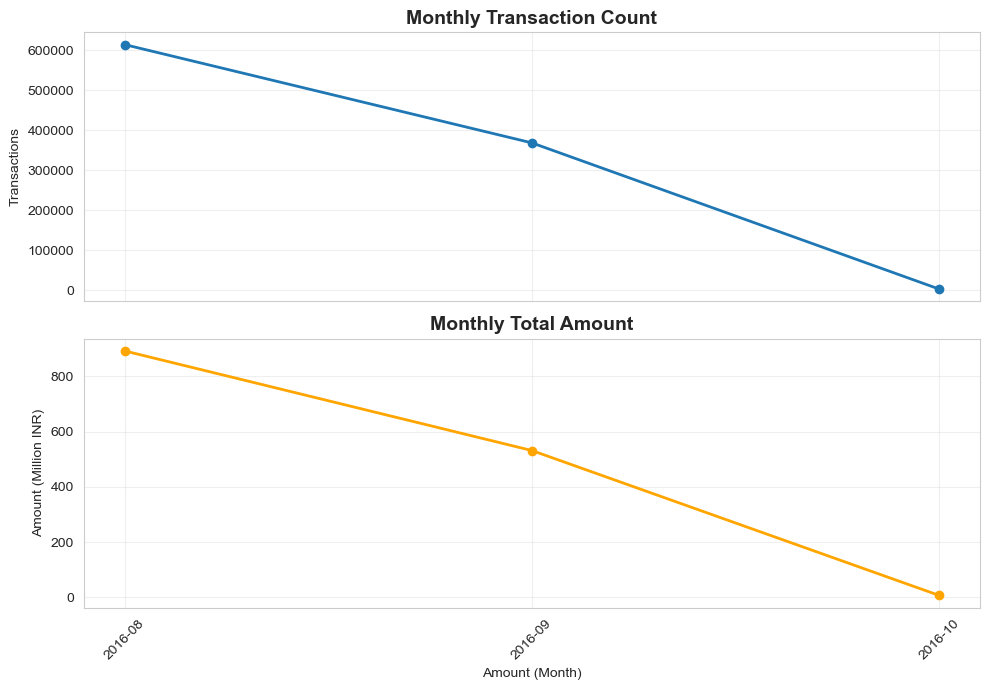

,YearMonth,tx_counts,total_amount
0,2016-08,613605,892697759.61
1,2016-09,368307,531748036.66
2,2016-10,3410,6660655.99


In [47]:
# Monthly and yearly trend

df["YearMonth"] = df["TransactionDate"].dt.to_period("M").astype(str)
monthly = df.groupby("YearMonth").agg(
    tx_counts=("TransactionID", "count"),
    total_amount=("TransactionAmount", "sum")
).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
axes[0].plot(monthly["YearMonth"], monthly["tx_counts"], marker="o", linewidth=2)
axes[0].set_title("Monthly Transaction Count", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Transactions")
axes[0].grid(True, alpha=0.3)

axes[1].plot(monthly["YearMonth"], monthly["total_amount"]/1e6, marker="o", color="orange", linewidth=2)
axes[1].set_title("Monthly Total Amount", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Amount (Million INR)")
axes[1].set_xlabel("Amount (Month)")
axes[1].grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly

##### ***Insights***
* Declining trend: Both transaction volumn and amount decline sharply from August to October
* August had 613,605 transactions, while, October had only 3410
* Possible explanation:
    * Data collection window (August = full month, October = partial)
    * Data quality issue(missing October date)
    * Seasonal effect (post-festival slowdown)

In [49]:
df_cleaned = df.copy()

In [50]:
df_cleaned.to_csv("cleaned_data.csv", index=False)